# Bayesian Regression with Pyro 

Must run in the pyro conda environment

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import os

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints



import pyro
from pyro.nn import PyroSample
from pyro.nn import PyroModule
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive
import pyro.distributions as dist

In [88]:
pyro.enable_validation(True)

## Traditional linear regression with Pytorch

In [40]:
def linear_data(x):
    # define the hyperparameters that control the beta prior
    beta0 = torch.tensor(1.0)
    beta1 = torch.tensor(1.0)
    sigma = torch.tensor(1.0)
    
    y = torch.tensor([ torch.distributions.normal.Normal(beta0 + beta1*z, sigma).sample() for z in x])
    return y

In [47]:
def model(x, y):
    beta0 = torch.tensor(1.0)
    beta1 = torch.tensor(1.0)
    sigma = torch.tensor(1.0)
    
    with pyro.plate('observed_data'):
        pyro.sample('obs', dist.Normal(beta0 + beta1*x, sigma))

In [48]:
def guide(x, y):
    alpha = pyro.param("alpha", torch.tensor(1.0), constraint=constraints.positive)
    mu0 = pyro.param("mu0", torch.tensor(1.0))
    sig0 = pyro.param("sig0", torch.tensor(1.0), constraint=constraints.positive)
    mu1 = pyro.param("mu1", torch.tensor(1.0))
    sig1 = pyro.param("sig1", torch.tensor(1.0), constraint=constraints.positive)
    

    beta0 = pyro.sample('beta0', dist.Normal(mu0, sig0))
    beta1 = pyro.sample('beta1', dist.Normal(mu1, sig1))
    
    sigma = pyro.sample('sigma', dist.HalfCauchy(alpha))
    
    with pyro.plate('observed_data'):
        pyro.sample('obs', dist.Normal(beta0 + beta1*x, sigma), obs=y)

In [103]:
dist.Normal(0., 1.).expand([3, 1])

Normal(loc: torch.Size([3, 1]), scale: torch.Size([3, 1]))

In [ ]:
dist.Normal(0., 1.).expand

In [61]:
def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

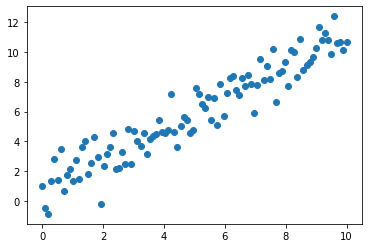

In [60]:
x_data = torch.linspace(0, 10, 100)
y_data = linear_data(x_data)
plt.plot(x_data, y_data, 'o')

In [71]:
x_data = torch.linspace(0, 10, 100)
y_data = linear_data(x_data)
x_data = x_data.reshape((100, 1))

In [73]:
# Regression model
linear_reg_model = PyroModule[nn.Linear](1, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 10000 

In [74]:
for j in range(num_iterations):
    loss = train()
    if (j + 1) % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

[iteration 1000] loss: 86.1408
[iteration 2000] loss: 86.1408
[iteration 3000] loss: 86.1408
[iteration 4000] loss: 86.1408
[iteration 5000] loss: 86.1408
[iteration 6000] loss: 86.1408
[iteration 7000] loss: 86.1408
[iteration 8000] loss: 86.1408
[iteration 9000] loss: 86.1408
[iteration 10000] loss: 86.1408


In [75]:
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

weight [[1.0489254]]
bias [1.0122889]


In [77]:
y_fit = linear_reg_model(x_data).detach().cpu().numpy()[:,0]

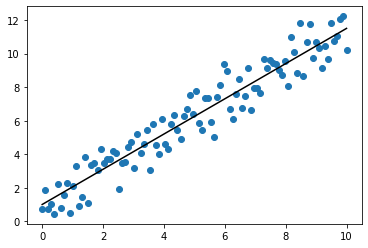

In [78]:
plt.plot(x_data[:,0], y_data, 'o')
plt.plot(x_data[:,0], y_fit, 'k')

## Regression with Bayesian sampling 

In [84]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [94]:
model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)

In [95]:
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [98]:
pyro.clear_param_store()
for j in range(1000):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))

[iteration 0001] loss: 1.4821
[iteration 0101] loss: 1.4878
[iteration 0201] loss: 1.4775
[iteration 0301] loss: 1.4843
[iteration 0401] loss: 1.4826
[iteration 0501] loss: 1.4886
[iteration 0601] loss: 1.4763
[iteration 0701] loss: 1.4912
[iteration 0801] loss: 1.5012
[iteration 0901] loss: 1.4885


In [99]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2515,  1.0348,  1.0199])
AutoDiagonalNormal.scale tensor([0.0765, 0.0163, 0.0920])


In [100]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(0.9086), tensor(0.9522), tensor(0.9976)],
 'linear.weight': [tensor([[1.0238]]), tensor([[1.0348]]), tensor([[1.0458]])],
 'linear.bias': [tensor([0.9578]), tensor([1.0199]), tensor([1.0820])]}

In [107]:
for param in guide.parameters():
    print(param)

Parameter containing:
tensor([-2.2515,  1.0348,  1.0199])
Parameter containing:
tensor([-2.5699, -4.1146, -2.3855])


In [110]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [117]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = {
    "x_data": x_data[:, 0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y_data": y_data
}

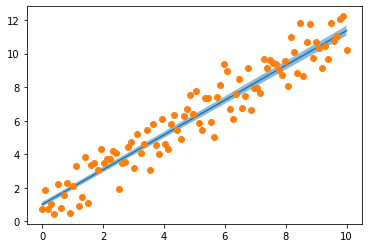

In [124]:
plt.plot(x_data, predictions['mu_mean'])
plt.fill_between(x_data[:,0], predictions['mu_perc_5'], predictions['mu_perc_95'], alpha=0.5)
plt.plot(x_data, y_data, 'o')

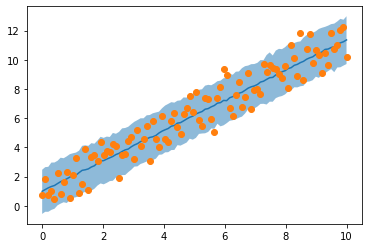

In [123]:
plt.fill_between(x_data[:,0], predictions['y_perc_5'], predictions['y_perc_95'], alpha=0.5)
plt.plot(x_data, predictions['y_mean'])
plt.plot(x_data, y_data, 'o')

In [ ]:
cond_model = pyro.condition(model, )

## Biased coin

In [49]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [51]:
elbo = []
n_steps = 2000
# do gradient steps
for step in range(n_steps):
    elbo.append(svi.evaluate_loss(x, y))
    svi.step(x, y)
    if step % 100 == 0:
        print('.', end='')

RuntimeError: site obs must be sample in trace
Trace Shapes:
 Param Sites:
Sample Sites:

In [3]:
n_steps = 2000

In [76]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

In [31]:
# create some data with 6 observed heads and 4 observed tails
data = torch.zeros(100)
data[0:30] = torch.ones(30)

In [32]:
def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(2.0)
    beta0 = torch.tensor(2.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    with pyro.plate('observed_data'):  # ARGUMENT 'DEVICE' FOR GPU?
        pyro.sample('obs', dist.Bernoulli(f), obs=data)

In [33]:
def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [34]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [35]:
elbo = []
# do gradient steps
for step in range(n_steps):
    elbo.append(svi.evaluate_loss(data))
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

....................

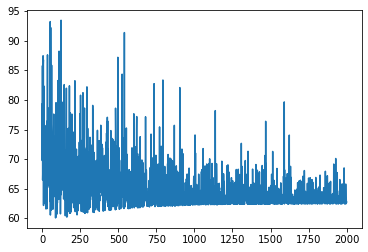

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(elbo)

In [37]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

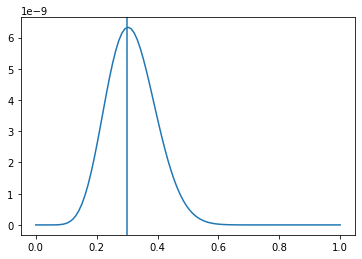

In [109]:
q = np.linspace(0, 1, 100)
y = (q**(alpha_q - 1))*((1 - q)**(beta_q - 1))
plt.plot(q, y)
plt.axvline(0.3)

In [38]:
# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

In [39]:
print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.315 +- 0.080


## Categorical distribution

In [77]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

In [78]:
n_sides = 6
probs = torch.ones(n_sides)
probs[0] = 5.
#probs = torch.tensor([ 1./n_sides for i in range(n_sides) ])
probs = probs / float(probs.sum())

In [79]:
probs

tensor([0.5000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000])

In [82]:
Cat = dist.Categorical(probs=probs)

In [105]:
pyro.sample('temp', dist.Dirichlet(torch.ones(n_sides)))

tensor([0.6260, 0.0644, 0.0374, 0.0958, 0.1578, 0.0187])

In [106]:
def model(data, n_sides):
    alpha = torch.ones(n_sides)
    probs = pyro.sample('probs', dist.Dirichlet(alpha))
    with pyro.plate('observed_data'):
        pyro.sample('obs', dist.Categorical(probs), obs=data)

In [107]:
data = torch.Tensor(x)

In [71]:
data = []
for i in range(10000):
    data.append(Cat())

(array([5082., 1020.,  988., 1006.,  942.,  962.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Patch objects>)

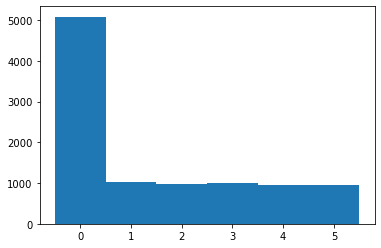

In [93]:
plt.hist(x, bins=np.arange(7) - 0.5)

In [46]:
data = []
for i in range(100):
    data.append(m.sample())

## Logistics regression
#### Cooking up some data

In [168]:
class LogitRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        eta = self.linear(x).squeeze(-1)
        mu = nn.Sigmoid()(eta)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(mu), obs=y)
        return mu

In [153]:
def logit_data(x):
    eta = linear_data(x)
    mu = eta.sigmoid()
    return pyro.sample('Y', dist.Bernoulli(mu))

In [159]:
x_data_logit = torch.linspace(-3, 3, 100)
y_data_logit = logit_data(x_data_logit)

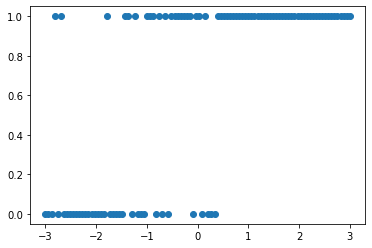

In [163]:
plt.plot(x_data_logit, y_data_logit, 'o')

In [169]:
model_l = LogitRegression(1, 1)
guide_l = AutoDiagonalNormal(model_l)

In [170]:
#adam = pyro.optim.Adam({"lr": 0.03})
svi_l = SVI(model_l, guide_l, adam, loss=Trace_ELBO())

In [171]:
pyro.clear_param_store()
for j in range(1000):
    # calculate the loss and take a gradient step
    loss = svi_l.step(x_data_logit.reshape((-1, 1)), y_data_logit)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data_logit)))

[iteration 0001] loss: 1.8528
[iteration 0101] loss: 0.5066
[iteration 0201] loss: 0.4301
[iteration 0301] loss: 0.4180
[iteration 0401] loss: 0.4163
[iteration 0501] loss: 0.4109
[iteration 0601] loss: 0.4159
[iteration 0701] loss: 0.4025
[iteration 0801] loss: 0.4131
[iteration 0901] loss: 0.4131


In [172]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-0.1635,  1.3050,  1.2794], requires_grad=True)
AutoDiagonalNormal.scale tensor([1.8753, 0.2028, 0.2803], grad_fn=<AddBackward0>)


In [174]:
guide_l.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(1.9335, grad_fn=<AddBackward0>),
  tensor(4.5923, grad_fn=<AddBackward0>),
  tensor(7.5053, grad_fn=<AddBackward0>)],
 'linear.weight': [tensor([[1.1683]], grad_fn=<ViewBackward>),
  tensor([[1.3050]], grad_fn=<ViewBackward>),
  tensor([[1.4418]], grad_fn=<ViewBackward>)],
 'linear.bias': [tensor([1.0903], grad_fn=<ViewBackward>),
  tensor([1.2794], grad_fn=<ViewBackward>),
  tensor([1.4685], grad_fn=<ViewBackward>)]}